# Check libraries and CUDA

In [15]:
#import os

#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

#torch.cuda.empty_cache()

#print(torch.cuda.memory_summary())

In [16]:
pip install --upgrade transformers

  Using cached transformers-4.46.2-py3-none-any.whl.metadata (44 kB)
Using cached transformers-4.46.2-py3-none-any.whl (10.0 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1
Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np

import pandas as pd

import time

import datetime

import gc

import random

#from nltk.corpus import stopwords

import nltk

import re

from tabulate import tabulate

from tqdm import trange



import torch

import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report



import transformers

from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup



#verificare la disponibilità di cuda

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#torch.cuda.empty_cache()

device

device(type='cuda', index=0)

# Load Dataset

In [18]:
dataset_path = '/kaggle/input/steam-reviews/dataset.csv'

df = pd.read_csv(dataset_path)


# Drop and Rename columns

In [19]:
df = df.drop(columns=['app_id', 'app_name', 'review_votes'])

df = df.rename(columns={'review_score': 'label', 'review_text': 'text'})

df = df.dropna()

In [20]:

shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df.head()

,text,label
0,10/10 Made me cry like a baby.,1
1,This game is nowhere near as perfect as Morrow...,1
2,Best way how to learn foreign languagues just ...,1
3,This is a awesome game you should play with yo...,1
4,Dota 2 is many things to many people: it's a g...,1


In [21]:
df.head()

,text,label
0,Ruined my life.,1
1,This will be more of a ''my experience with th...,1
2,This game saved my virginity.,1
3,• Do you like original games? • Do you like ga...,1
4,"Easy to learn, hard to master.",1


# Create undersampled dataset

In [22]:
# ...

positive_reviews = df[df['label'] == 1]

negative_reviews = df[df['label'] == -1]
negative_reviews['label'] = 0



# Randomly sample 50,000 rows from each label group

positive_sample = positive_reviews.sample(n=50000, random_state=777)

negative_sample = negative_reviews.sample(n=50000, random_state=777)



# Concatenate the samples and shuffle the resulting DataFrame

balanced_df = pd.concat([positive_sample, negative_sample]).sample(frac=1, random_state=42).reset_index(drop=True)



sampled_dataset_path = '/kaggle/working/sampled_dataset.csv'



# Save or use `balanced_df` as your balanced dataset

balanced_df.to_csv(sampled_dataset_path, index=False)

/tmp/ipykernel_31/661215253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['label'] = 0


# Load it

In [23]:
sampled_dataset_path = '/kaggle/working/sampled_dataset.csv'

df = pd.read_csv(sampled_dataset_path)

df

,text,label
0,Early Access Review,0
1,"In it's current state, it was unplayable for m...",0
2,This game was fun but starting over everytime ...,1
3,Was fun while it lasted. It got boring pretty ...,0
4,"cannot change to widescreen mode, rubbish",0
...,...,...
99995,Early Access Review,1
99996,Early Access Review,0
99997,Early Access Review,0
99998,Only reason it has a 67 Metascore is probably ...,1


# Preprocessing

## Remove stopwords

In [24]:
from nltk.corpus import stopwords

nltk.download('stopwords')

sw = stopwords.words('english')



def clean_text(text):



    text = text.lower()



    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")



    text = re.sub(r"http\S+", "",text) #Removing URLs

    #text = re.sub(r"http", "",text)



    html=re.compile(r'<.*?>')



    text = html.sub(r'',text) #Removing html tags



    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'

    for p in punctuations:

        text = text.replace(p,'') #Removing punctuations



    text = [word.lower() for word in text.split() if word.lower() not in sw]



    text = " ".join(text) #removing stopwords



    emoji_pattern = re.compile("["

                           u"\U0001F600-\U0001F64F"  # emoticons

                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs

                           u"\U0001F680-\U0001F6FF"  # transport & map symbols

                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)

                           u"\U00002702-\U000027B0"

                           u"\U000024C2-\U0001F251"

                           "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text) #Removing emojis



    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

df

,text,label
0,early access review,0
1,"current state, unplayable signed on, character...",0
2,game fun starting everytime,1
3,fun lasted got boring pretty quickly though,0
4,"cannot change widescreen mode, rubbish",0
...,...,...
99995,early access review,1
99996,early access review,0
99997,early access review,0
99998,reason metascore probably devs want pay critic...,1


In [26]:
reviews = df.text.values

labels = df.label.values

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [28]:
index=1

print(' Original: ', reviews[index])



#print('Tokenized: ', tokenizer.tokenize(tweets[index])) # Print the sentence split into tokens.



#print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[index]))) # Print the sentence mapped to token ids.



table = np.array([tokenizer.tokenize(reviews[index]),

                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews[index]))]).T

print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))


 Original:  current state, unplayable signed on, character jogged place idled way stop jogging place also move side side keys asked normal, somebody told huge problem fact everytime step, make foot clunking noise distracting trying listen danger also annoying maybe give another shot future get rid bugs fix walking otherwise seems like decent sandbox get see get see much disconnected times minutes rather annoying hell
╒══════════════╤═════════════╕
│ Tokens       │   Token IDs │
╞══════════════╪═════════════╡
│ current      │        2783 │
├──────────────┼─────────────┤
│ state        │        2110 │
├──────────────┼─────────────┤
│ ,            │        1010 │
├──────────────┼─────────────┤
│ un           │        4895 │
├──────────────┼─────────────┤
│ ##play       │       13068 │
├──────────────┼─────────────┤
│ ##able       │        3085 │
├──────────────┼─────────────┤
│ signed       │        2772 │
├──────────────┼─────────────┤
│ on           │        2006 │
├──────────────┼─────

## Add special tokens

In [29]:
max_len = 0



# For every sentence...

for sent in reviews:



    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    # Sequenze troncate a 512 poichè è la massima lunghezza gestibile dal tokenizer

    input_ids = tokenizer.encode(sent[:512], add_special_tokens=True)



    # Update the maximum sentence length.

    max_len = max(max_len, len(input_ids))



print('Max sentence length: ', max_len)

     


Max sentence length:  258


In [30]:
input_ids = []

attention_masks = []



# For every tweet...

for review in reviews:

    # `encode_plus` will:

    #   (1) Tokenize the sentence.

    #   (2) Prepend the `[CLS]` token to the start.

    #   (3) Append the `[SEP]` token to the end.

    #   (4) Map tokens to their IDs.

    #   (5) Pad or truncate the sentence to `max_length`

    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(

                        review,                      # Sentence to encode.

                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        max_length = max_len,           # Pad & truncate all sentences.

                        truncation=True,

                        pad_to_max_length = True,

                        return_attention_mask = True,   # Construct attn. masks.

                        return_tensors = 'pt',     # Return pytorch tensors.

                   )



    # Add the encoded sentence to the list.

    input_ids.append(encoded_dict['input_ids'])



    # And its attention mask (simply differentiates padding from non-padding).

    attention_masks.append(encoded_dict['attention_mask'])



# Convert the lists into tensors.

input_ids = torch.cat(input_ids, dim=0)

attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.tensor(labels)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2837: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  "use `padding='max_length'` to pad to a max length. In this case, you can give a specific "


In [31]:
# Print sentence 0, now as a list of IDs.

i=random.randint(0,len(reviews)-1)

print('Original: ', reviews[i])

print('Input IDs:', input_ids[i])

Original:  know cod kids always raging playing tf
Input IDs: tensor([  101,  2113, 19429,  4268,  2467, 17559,  2652,  1056,  2546,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [32]:
def print_rand_sentence_encoding():

  '''Displays tokens, token IDs and attention mask of a random text sample'''

  index = random.randint(0, len(reviews) - 1)

  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))

  token_ids = [i.numpy() for i in input_ids[index]]

  attention = [i.numpy() for i in attention_masks[index]]



  table = np.array([tokens, token_ids, attention]).T

  print(reviews[index])

  print(tabulate(table,

                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],

                 tablefmt = 'fancy_grid'))



print_rand_sentence_encoding()

thought game going like karaoke revolution vocal part rockband guitar hero wrong game says good job singing noise picked microphones talking, laughing, singing one note, even scratching microphone getting perfect scores please pass
╒════════════╤═════════════╤══════════════════╕
│ Tokens     │   Token IDs │   Attention Mask │
╞════════════╪═════════════╪══════════════════╡
│ [CLS]      │         101 │                1 │
├────────────┼─────────────┼──────────────────┤
│ thought    │        2245 │                1 │
├────────────┼─────────────┼──────────────────┤
│ game       │        2208 │                1 │
├────────────┼─────────────┼──────────────────┤
│ going      │        2183 │                1 │
├────────────┼─────────────┼──────────────────┤
│ like       │        2066 │                1 │
├────────────┼─────────────┼──────────────────┤
│ kara       │       13173 │                1 │
├────────────┼─────────────┼──────────────────┤
│ ##oke      │       11045 │                1 │


# Train Validation Split

In [33]:
# Combine the training inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, labels)





# Calculate the number of samples to include in each set.

# train 0.7

train_size = int(0.7 * len(dataset))

val_test_size = len(dataset)  - train_size

# validation 0.15

# test 0.15



val_size =  int(0.5 * val_test_size)

test_size = val_test_size - val_size

print(val_test_size)

print(val_size)



# Divide the dataset by randomly selecting samples.

train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size])

val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])



print('{:>5,} training samples'.format(train_size))

print('{:>5,} validation samples'.format(val_size))

print('{:>5,} test samples'.format(test_size))

30000
15000
70,000 training samples
15,000 validation samples
15,000 test samples


In [34]:


# The DataLoader needs to know our batch size for training, so we specify it

# here. For fine-tuning BERT on a specific task, the authors recommend a batch

# size of 16 or 32.

batch_size = 32



# Create the DataLoaders for our training and validation sets.

# We'll take training samples in random order.

train_dataloader = DataLoader(

            train_dataset,  # The training samples.

            sampler = RandomSampler(train_dataset), # Select batches randomly

            batch_size = batch_size # Trains with this batch size.

        )



# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(

            val_dataset, # The validation samples.

            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.

            batch_size = batch_size # Evaluate with this batch size.

        )



# For validation the order doesn't matter, so we'll just read them sequentially.

test_dataloader = DataLoader(

            test_dataset, # The test samples.

            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.

            batch_size = batch_size # Evaluate with this batch size.

        )

# Some Prediction Metrics

In [35]:
def b_tp(preds, labels):

  '''Returns True Positives (TP): count of correct predictions of actual class 1'''

  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])



def b_fp(preds, labels):

  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''

  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])



def b_tn(preds, labels):

  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''

  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])



def b_fn(preds, labels):

  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''

  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])



def b_metrics(preds, labels):

  '''

  Returns the following metrics:

    - accuracy    = (TP + TN) / N

    - precision   = TP / (TP + FP)

    - recall      = TP / (TP + FN)

    - specificity = TN / (TN + FP)

  '''

  preds = np.argmax(preds, axis = 1).flatten()

  labels = labels.flatten()

  tp = b_tp(preds, labels)

  tn = b_tn(preds, labels)

  fp = b_fp(preds, labels)

  fn = b_fn(preds, labels)

  b_accuracy = (tp + tn) / len(labels)

  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'

  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'

  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'

  return b_accuracy, b_precision, b_recall, b_specificity

# Create Bert Model

In [36]:




# Load BertForSequenceClassification, the pretrained BERT model with a single

# linear classification layer on top.

model = BertForSequenceClassification.from_pretrained(

    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.

    num_labels = 2, # The number of output labels--2 for binary classification.

                    # You can increase this for multi-class tasks.

    output_attentions = False, # Whether the model returns attentions weights.

    output_hidden_states = False, # Whether the model returns all hidden-states.

)



# if device == "cuda:0":

# # Tell pytorch to run this model on the GPU.

model = model.cuda()

#model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
optimizer = AdamW(model.parameters(),

                  lr = 2e-5, # args.learning_rate - default is 5e-5

                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.

                )

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Model Fine Tuning

In [38]:


# Number of training epochs. The BERT authors recommend between 2 and 4.

# We chose to run for 4, but we'll see later that this may be over-fitting the

# training data.

epochs = 4



# Total number of training steps is [number of batches] x [number of epochs].

# (Note that this is not the same as the number of training samples).

total_steps = len(train_dataloader) * epochs



# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer,

                                            num_warmup_steps = 0, # Default value in run_glue.py

                                            num_training_steps = total_steps)

In [39]:
# Function to calculate the accuracy of our predictions vs labels

def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()

    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [40]:
def format_time(elapsed):

    '''

    Takes a time in seconds and returns a string hh:mm:ss

    '''

    # Round to the nearest second.

    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [41]:
epochs = 4

train_losses = []
validation_losses = []

epoch_times = []

for _ in trange(epochs, desc = 'Epoch'):

    start_time = time.time()


    # ========== Training ==========



    # Set model to training mode

    model.train()



    # Tracking variables

    tr_loss = 0

    nb_tr_examples, nb_tr_steps = 0, 0



    for step, batch in enumerate(train_dataloader):

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        # Forward pass

        train_output = model(b_input_ids,

                             token_type_ids = None,

                             attention_mask = b_input_mask,

                             labels = b_labels)

        # Backward pass

        train_output.loss.backward()

        optimizer.step()

        # Update tracking variables

        tr_loss += train_output.loss.item()

        nb_tr_examples += b_input_ids.size(0)

        nb_tr_steps += 1



    # ========== Validation ==========



    # Set model to evaluation mode

    model.eval()



    # Tracking variables

    val_accuracy = []

    val_precision = []

    val_recall = []

    val_specificity = []


    val_loss = 0
    nb_val_steps = 0



    for batch in validation_dataloader:

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():

          # Forward pass

          eval_output = model(b_input_ids,

                              token_type_ids = None,

                              attention_mask = b_input_mask,
                              
                              labels = b_labels)
            
        val_loss += eval_output.loss.item()
        nb_val_steps += 1

        

        logits = eval_output.logits.detach().cpu().numpy()

        label_ids = b_labels.to('cpu').numpy()

        # Calculate validation metrics

        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)

        val_accuracy.append(b_accuracy)

        # Update precision only when (tp + fp) !=0; ignore nan

        if b_precision != 'nan': val_precision.append(b_precision)

        # Update recall only when (tp + fn) !=0; ignore nan

        if b_recall != 'nan': val_recall.append(b_recall)

        # Update specificity only when (tn + fp) !=0; ignore nan

        if b_specificity != 'nan': val_specificity.append(b_specificity)



    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    train_losses.append(tr_loss / nb_tr_steps)

    print('\n\t - Validaton loss: {:.4f}'.format(val_loss / nb_val_steps))
    validation_losses.append(val_loss / nb_val_steps)

    end_time = time.time()
    epoch_times.append(end_time - start_time)
    print(f'{format_time(end_time - start_time)}')

    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))

    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')

    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')

    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  25%|██▌       | 1/4 [30:41<1:32:05, 1841.69s/it]


	 - Train loss: 0.4379

	 - Validaton loss: 0.3907
0:30:42
	 - Validation Accuracy: 0.8027
	 - Validation Precision: 0.8350
	 - Validation Recall: 0.7509
	 - Validation Specificity: 0.8525



Epoch:  50%|█████     | 2/4 [1:01:34<1:01:36, 1848.23s/it]


	 - Train loss: 0.3456

	 - Validaton loss: 0.3889
0:30:53
	 - Validation Accuracy: 0.8050
	 - Validation Precision: 0.9045
	 - Validation Recall: 0.6783
	 - Validation Specificity: 0.9294



Epoch:  75%|███████▌  | 3/4 [1:32:29<30:51, 1851.54s/it]  


	 - Train loss: 0.2668

	 - Validaton loss: 0.4237
0:30:55
	 - Validation Accuracy: 0.8094
	 - Validation Precision: 0.8626
	 - Validation Recall: 0.7338
	 - Validation Specificity: 0.8845



Epoch: 100%|██████████| 4/4 [2:03:27<00:00, 1851.81s/it]


	 - Train loss: 0.2076

	 - Validaton loss: 0.4794
0:30:57
	 - Validation Accuracy: 0.8080
	 - Validation Precision: 0.8636
	 - Validation Recall: 0.7285
	 - Validation Specificity: 0.8855



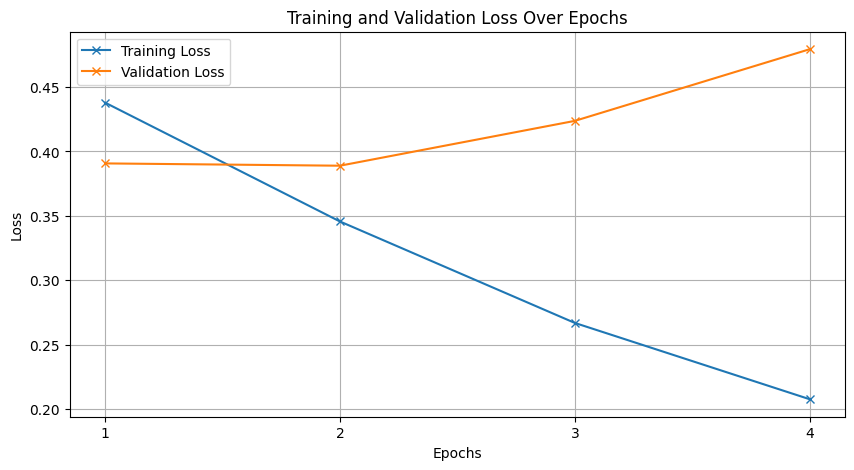

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='x')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss', marker ='x')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.savefig("bert_losses.png", dpi=300, bbox_inches='tight')
plt.show()

# Test

In [47]:


# Tracking variables

val_accuracy = []

val_precision = []

val_recall = []

val_specificity = []

true_labels = []
pred_labels = []


for batch in test_dataloader:

  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():

    # Forward pass

    eval_output = model(b_input_ids,

                        token_type_ids = None,

                        attention_mask = b_input_mask,

                        labels = b_labels)

  logits = eval_output.logits.detach().cpu().numpy()

  label_ids = b_labels.to('cpu').numpy()
  predictions = np.argmax(logits, axis=1)

  # Calculate validation metrics

  # Append to tracking lists
  true_labels.extend(label_ids)
  pred_labels.extend(predictions)

  b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)

  val_accuracy.append(b_accuracy)

  # Update precision only when (tp + fp) !=0; ignore nan

  if b_precision != 'nan': val_precision.append(b_precision)

  # Update recall only when (tp + fn) !=0; ignore nan

  if b_recall != 'nan': val_recall.append(b_recall)

  # Update specificity only when (tn + fp) !=0; ignore nan

  if b_specificity != 'nan': val_specificity.append(b_specificity)



print('\t - Test Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))

print('\t - Test Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Test Precision: NaN')

print('\t - Test Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Test Recall: NaN')

print('\t - Test Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Test Specificity: NaN')

     

	 - Test Accuracy: 0.8000
	 - Test Precision: 0.8641
	 - Test Recall: 0.7180
	 - Test Specificity: 0.8838



Confusion Matrix:
 [[6553  860]
 [2140 5447]]


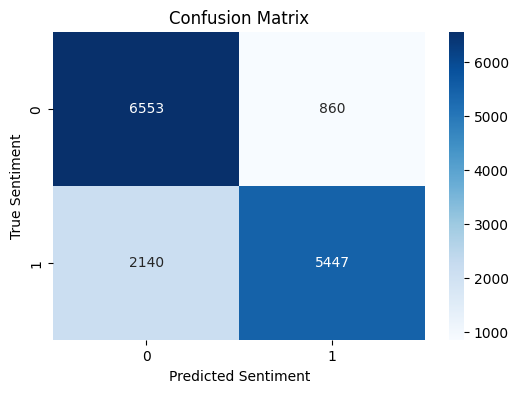

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:\n", conf_matrix)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.title("Confusion Matrix")
plt.savefig("conf_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
